In [7]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, Add, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Charge npy files
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [ ]:
# Charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../../Facenet Embeddings/Train/X_train.npy'
path_val   = '../../../../Facenet Embeddings/Val/X_val.npy'
path_test  = '../../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

X = np.concatenate((X_val, X_test), axis=0)
y = np.concatenate((y_val, y_test), axis=0)

In [4]:
# Divide data in Val and test
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=123, stratify=y)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((5481, 5, 128), (1721, 5, 128), (1722, 5, 128), (5481,), (1721,), (1722,))

In [5]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 40.3014705882353,
 1: 6.40303738317757,
 2: 0.5172706681766704,
 3: 0.5302825077399381}

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    x = LayerNormalization()(inputs)

    # Stacked Transformer Encoders
    for _ in range(3):
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    
    return model

# Create and train the Transformer model with 3 enconders
model = build_transformer_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/1000


I0000 00:00:1747001241.552506  103572 service.cc:146] XLA service 0x7f268c0025c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747001241.552543  103572 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-11 17:07:21.709193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-11 17:07:22.376026: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 16/172 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4457 - loss: 1.6545

I0000 00:00:1747001248.417857  103572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.3459 - loss: 1.8449 - val_accuracy: 0.3858 - val_loss: 1.2849 - learning_rate: 1.0000e-04
Epoch 2/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3557 - loss: 1.5076 - val_accuracy: 0.2231 - val_loss: 1.4271 - learning_rate: 1.0000e-04
Epoch 3/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3478 - loss: 1.2479 - val_accuracy: 0.2592 - val_loss: 1.3694 - learning_rate: 1.0000e-04
Epoch 4/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3346 - loss: 1.4246 - val_accuracy: 0.3881 - val_loss: 1.2732 - learning_rate: 1.0000e-04
Epoch 5/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3802 - loss: 1.2307 - val_accuracy: 0.3678 - val_loss: 1.2560 - learning_rate: 1.0000e-04
Epoch 6/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3654 - loss: 1.2802 - val_accuracy: 0.3510 - val_loss: 1.2775 - learning_rate: 1.0000e-04
Epoch 7/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accurac

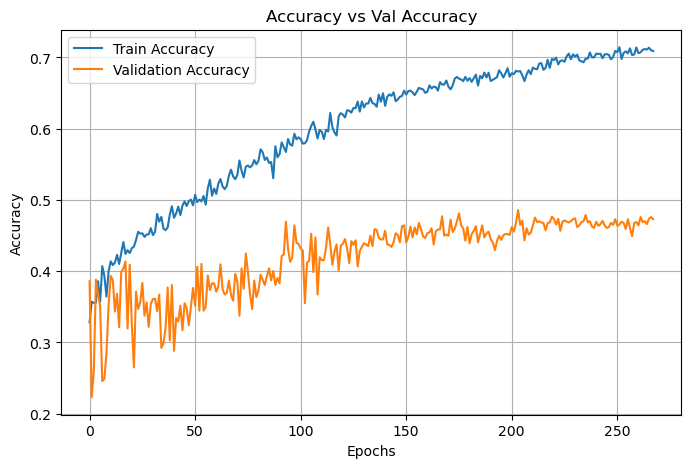

In [9]:
# Train Accuracy vs Val Accuracy 
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

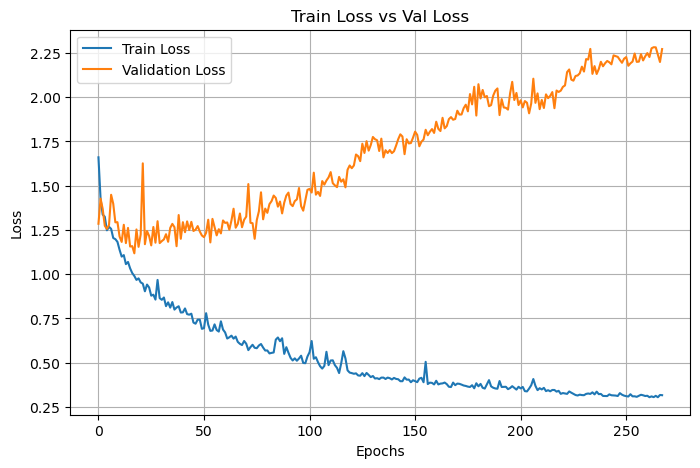

In [10]:
# Train Loss vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Train Loss vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Predictions
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


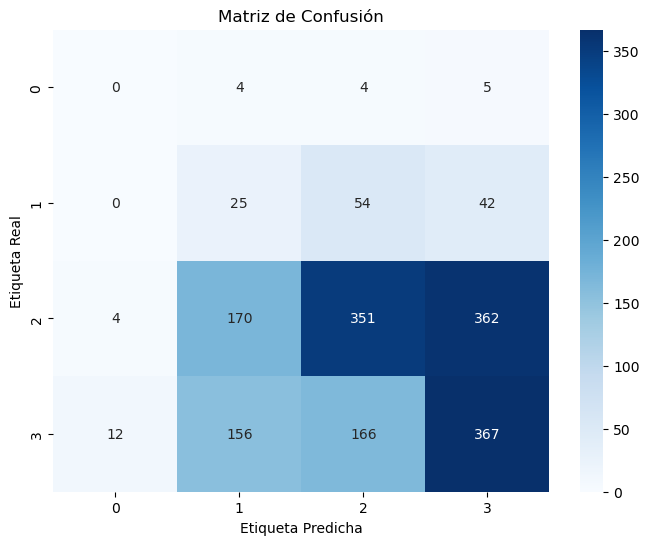

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [13]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.070     0.207     0.105       121
           2      0.610     0.396     0.480       887
           3      0.473     0.524     0.497       701

    accuracy                          0.431      1722
   macro avg      0.288     0.281     0.271      1722
weighted avg      0.512     0.431     0.457      1722



In [14]:
# UAR metric
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, final_preds)
print(f'UAR: {uar_score:.4f}')

UAR: 0.2815
